In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import seaborn as sns

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df = pd.read_csv(url)

In [26]:
df.shape

(284807, 31)

In [27]:
class_0 = df['Class'].value_counts()[0]
class_1 = df['Class'].value_counts()[1]

class_1_prop = df['Class'].value_counts()[1]/df['Class'].value_counts().sum()

In [28]:
print(f'Number of Non Fraud transactions: {class_0}')
print(f'Number of Fraud transactions: {class_1}')
print(f'Percentage of Fraud transactions: {round(class_1_prop, 5) * 100} %')

Number of Non Fraud transactions: 284315
Number of Fraud transactions: 492
Percentage of Fraud transactions: 0.173 %


In [29]:
print(f'Missing values in the dataset {(df.isnull().sum()).sum()}')

Missing values in the dataset 0


### Train and test data

In [30]:
train, test = train_test_split(df, test_size=0.2, shuffle=True)

In [31]:
X_train = train.drop(columns='Class')
y_train = train['Class']

X_test = test.drop(columns='Class')
y_test = test['Class']

### Random Forest

In [32]:
rf_model = make_pipeline(RandomForestClassifier())

In [33]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [34]:
preds_train = rf_model.predict(X_train)
preds_test = rf_model.predict(X_test)

In [35]:
train_acc = accuracy_score(y_train, preds_train)
test_acc = accuracy_score(y_test, preds_test)

print(f'Train accuracy: {round(train_acc, 5)*100}')
print(f'Test accuracy: {round(test_acc, 5)*100}')

Train accuracy: 100.0
Test accuracy: 99.946


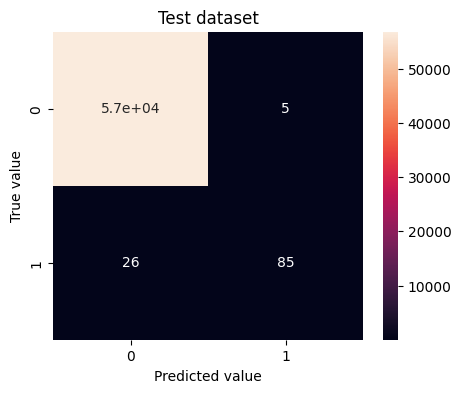

In [36]:
test_conf_matrix = confusion_matrix(y_test, preds_test)

plt.figure(figsize=(5,4))

sns.heatmap(test_conf_matrix, annot=True)

plt.title('Test dataset')
plt.xlabel('Predicted value')
plt.ylabel('True value')

plt.show()

#### In this case I would rather have the model warn about transactions that are not fraud than having fraud transactions going unnoticed

In [37]:
# Fraud predictions analysis
test_fraud_prediction_acc =  test_conf_matrix[1][1]/test_conf_matrix[1][:].sum()
print(f'Test dataset fraud prediction rate: {round(test_fraud_prediction_acc * 100, 1)}%')

Test dataset fraud prediction rate: 76.6%


In [38]:
false_alarms =  test_conf_matrix[0][1]
print(f'False alarms: {false_alarms}')

False alarms: 5


## Optimize to be more precise in predicting fraudulent transactions

### Method 1: Lower the classification threshold

In [39]:
preds_proba_test = rf_model.predict_proba(X_test)[:, 1]

threshold = 0.35

preds_proba_threshold_test = np.where(preds_proba_test <= threshold, 0, 1)

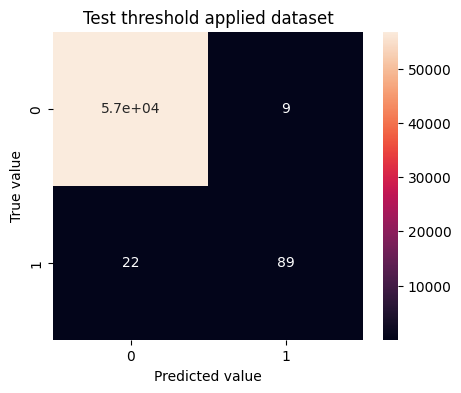

In [40]:
test_threshold_conf_matrix = confusion_matrix(y_test, preds_proba_threshold_test)

plt.figure(figsize=(5,4))

sns.heatmap(test_threshold_conf_matrix, annot=True)

plt.title('Test threshold applied dataset')
plt.xlabel('Predicted value')
plt.ylabel('True value')

plt.show()

In [58]:
# Fraud predictions analysis
test_fraud_threshold_prediction_acc =  test_threshold_conf_matrix[1][1]/test_threshold_conf_matrix[1][:].sum()
print(f'Test dataset fraud prediction rate: {round(test_fraud_threshold_prediction_acc * 100, 1)}%')

Test dataset fraud prediction rate: 80.2%


#### Takeaway: Basically every 1 fraud transaction we predict, we generate 5 more false alarms

### Method 2: Balance data (SMOTE)

In [41]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [42]:
rf_balanced_model = make_pipeline(RandomForestClassifier())

In [43]:
rf_balanced_model.fit(X_train_res, y_train_res)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [44]:
preds_balanced_train = rf_balanced_model.predict(X_train_res)
preds_balanced_test = rf_balanced_model.predict(X_test)

In [45]:
train_balanced_acc = accuracy_score(y_train_res, preds_balanced_train)
test_balanced_acc = accuracy_score(y_test, preds_balanced_test)

print(f'Train accuracy: {round(train_balanced_acc, 5)*100}')
print(f'Test accuracy: {round(test_balanced_acc, 5)*100}')

Train accuracy: 100.0
Test accuracy: 99.947


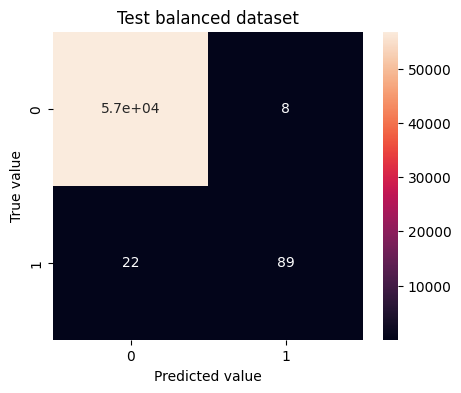

In [46]:
test_balanced_conf_matrix = confusion_matrix(y_test, preds_balanced_test)

plt.figure(figsize=(5,4))

sns.heatmap(test_balanced_conf_matrix, annot=True)

plt.title('Test balanced dataset')
plt.xlabel('Predicted value')
plt.ylabel('True value')

plt.show()

In [47]:
# Fraud predictions analysis
test_fraud_balanced_prediction_acc =  test_balanced_conf_matrix[1][1]/test_balanced_conf_matrix[1][:].sum()
print(f'Test dataset fraud prediction rate: {round(test_fraud_balanced_prediction_acc * 100, 1)}%')

Test dataset fraud prediction rate: 80.2%


In [48]:
balanced_false_alarms =  test_balanced_conf_matrix[0][1]
print(f'False alarms: {balanced_false_alarms}')

False alarms: 8


### Method 3: Balance dataset (class_weight = 'balanced')

In [49]:
rf_balanced2_model = make_pipeline(RandomForestClassifier(class_weight='balanced'))

In [50]:
rf_balanced2_model.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [51]:
preds_balanced2_train = rf_balanced2_model.predict(X_train)
preds_balanced2_test = rf_balanced2_model.predict(X_test)

In [52]:
train_balanced2_acc = accuracy_score(y_train, preds_balanced2_train)
test_balanced2_acc = accuracy_score(y_test, preds_balanced2_test)

print(f'Train accuracy: {round(train_balanced2_acc, 5)*100}')
print(f'Test accuracy: {round(test_balanced2_acc, 5)*100}')

Train accuracy: 100.0
Test accuracy: 99.94


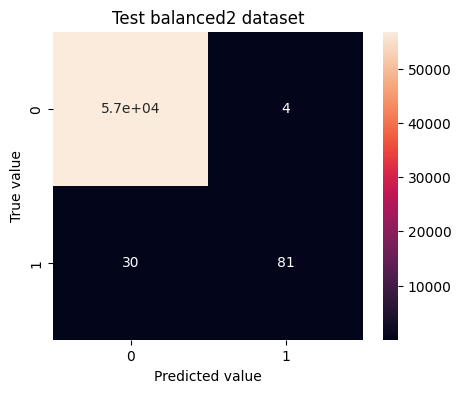

In [53]:
test_balanced2_conf_matrix = confusion_matrix(y_test, preds_balanced2_test)

plt.figure(figsize=(5,4))

sns.heatmap(test_balanced2_conf_matrix, annot=True)

plt.title('Test balanced2 dataset')
plt.xlabel('Predicted value')
plt.ylabel('True value')

plt.show()

In [54]:
# Fraud predictions analysis
test_balanced2_fraud_prediction_acc =  test_balanced2_conf_matrix[1][1]/test_balanced2_conf_matrix[1][:].sum()
print(f'Test dataset fraud prediction rate: {round(test_balanced2_fraud_prediction_acc * 100, 1)}%')

Test dataset fraud prediction rate: 73.0%


In [55]:
balanced2_false_alarms =  test_balanced2_conf_matrix[0][1]
print(f'False alarms: {balanced2_false_alarms}')

False alarms: 4


## Use SMOTE and GridSearch to get the best model

In [12]:
best_rf_model_pipeline = Pipeline([('smote', SMOTE(random_state=42)), ('rf', RandomForestClassifier(random_state=42))])

In [20]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

In [21]:
best_rf_model_grid_search = GridSearchCV(estimator=best_rf_model_pipeline, param_grid=param_grid, cv=5, scoring='f1', verbose=2)

In [ ]:
best_rf_model_grid_search.fit(X_train, y_train)

In [ ]:
best_rf_model_grid_search.best_params_

In [ ]:
preds_best_model_train = best_rf_model_grid_search.predict(X_train_res)
preds_best_model_test = best_rf_model_grid_search.predict(X_test)

In [ ]:
train_best_model_acc = accuracy_score(y_train, preds_best_model_train)
test_best_model_acc = accuracy_score(y_test, preds_best_model_test)

print(f'Train accuracy: {round(train_best_model_acc, 5)*100}')
print(f'Test accuracy: {round(test_best_model_acc, 5)*100}')

In [ ]:
test_best_model_conf_matrix = confusion_matrix(y_test, preds_best_model_test)

plt.figure(figsize=(5,4))

sns.heatmap(test_best_model_conf_matrix, annot=True)

plt.title('Test best model dataset')
plt.xlabel('Predicted value')
plt.ylabel('True value')

plt.show()

In [ ]:
# Fraud predictions analysis
test_fraud_best_model_prediction_acc =  test_best_model_conf_matrix[1][1]/test_best_model_conf_matrix[1][:].sum()
print(f'Test dataset fraud prediction rate: {round(test_fraud_best_model_prediction_acc * 100, 1)}%')

In [ ]:
best_model_false_alarms =  test_best_model_conf_matrix[0][1]
print(f'False alarms: {best_model_false_alarms}')